In [1]:
from keras import layers, models, Model, Sequential

import os
import glob
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gradio as gr
from PIL import Image

import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def GoogLeNet(im_height=224, im_width=224, class_num=1000, aux_logits=False):
    # tensorflow中的tensor通道排序是NHWC
    input_image = layers.Input(shape=(im_height, im_width, 3), dtype="float32")
    # (None, 224, 224, 3)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="SAME", activation="relu", name="conv2d_1")(input_image)
    # (None, 112, 112, 64)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_1")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(64, kernel_size=1, activation="relu", name="conv2d_2")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(192, kernel_size=3, padding="SAME", activation="relu", name="conv2d_3")(x)
    # (None, 56, 56, 192)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_2")(x)

    # (None, 28, 28, 192)
    x = Inception(64, 96, 128, 16, 32, 32, name="inception_3a")(x)
    # (None, 28, 28, 256)
    x = Inception(128, 128, 192, 32, 96, 64, name="inception_3b")(x)

    # (None, 28, 28, 480)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_3")(x)
    # (None, 14, 14, 480)
    x = Inception(192, 96, 208, 16, 48, 64, name="inception_4a")(x)
    if aux_logits:
        aux1 = InceptionAux(class_num, name="aux_1")(x)

    # (None, 14, 14, 512)
    x = Inception(160, 112, 224, 24, 64, 64, name="inception_4b")(x)
    # (None, 14, 14, 512)
    x = Inception(128, 128, 256, 24, 64, 64, name="inception_4c")(x)
    # (None, 14, 14, 512)
    x = Inception(112, 144, 288, 32, 64, 64, name="inception_4d")(x)
    if aux_logits:
        aux2 = InceptionAux(class_num, name="aux_2")(x)

    # (None, 14, 14, 528)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_4e")(x)
    # (None, 14, 14, 532)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_4")(x)

    # (None, 7, 7, 832)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_5a")(x)
    # (None, 7, 7, 832)
    x = Inception(384, 192, 384, 48, 128, 128, name="inception_5b")(x)
    # (None, 7, 7, 1024)
    x = layers.AvgPool2D(pool_size=7, strides=1, name="avgpool_1")(x)

    # (None, 1, 1, 1024)
    x = layers.Flatten(name="output_flatten")(x)
    # (None, 1024)
    x = layers.Dropout(rate=0.4, name="output_dropout")(x)
    x = layers.Dense(class_num, name="output_dense")(x)
    # (None, class_num)
    aux3 = layers.Softmax(name="aux_3")(x)

    if aux_logits:
        model = models.Model(inputs=input_image, outputs=[aux1, aux2, aux3])
    else:
        model = models.Model(inputs=input_image, outputs=aux3)
    return model

In [3]:
class Inception(layers.Layer):
    def __init__(self, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.branch1 = layers.Conv2D(ch1x1, kernel_size=1, activation="relu")

        self.branch2 = Sequential([
            layers.Conv2D(ch3x3red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch3x3, kernel_size=3, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch3 = Sequential([
            layers.Conv2D(ch5x5red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch5x5, kernel_size=5, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch4 = Sequential([
            layers.MaxPool2D(pool_size=3, strides=1, padding="SAME"),  # caution: default strides==pool_size
            layers.Conv2D(pool_proj, kernel_size=1, activation="relu")])                  # output_size= input_size

    def call(self, inputs, **kwargs):
        branch1 = self.branch1(inputs)
        branch2 = self.branch2(inputs)
        branch3 = self.branch3(inputs)
        branch4 = self.branch4(inputs)
        outputs = layers.concatenate([branch1, branch2, branch3, branch4])
        return outputs

In [4]:
class InceptionAux(layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(InceptionAux, self).__init__(**kwargs)
        self.averagePool = layers.AvgPool2D(pool_size=5, strides=3)
        self.conv = layers.Conv2D(128, kernel_size=1, activation="relu")

        self.fc1 = layers.Dense(1024, activation="relu")
        self.fc2 = layers.Dense(num_classes)
        self.softmax = layers.Softmax()

    def call(self, inputs, **kwargs):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(inputs)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = layers.Flatten()(x)
        x = layers.Dropout(rate=0.5)(x)
        # N x 2048
        x = self.fc1(x)
        x = layers.Dropout(rate=0.5)(x)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        x = self.softmax(x)

        return x

In [5]:
def main():
    # data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
    # image_path = os.path.join(data_root, "data_set", "flower_data")  # flower data set path
    train_dir = "C:/桌面/college/大四上/project/flower_dataset/flowers-K-youtube/Train"
    validation_dir = "C:/桌面/college/大四上/project/flower_dataset/flowers-K-youtube/Validate"
    assert os.path.exists(train_dir), "cannot find {}".format(train_dir)
    assert os.path.exists(validation_dir), "cannot find {}".format(validation_dir)

    # create direction for saving weights
    if not os.path.exists("save_weights"):
        os.makedirs("save_weights")

    im_height = 224
    im_width = 224
    batch_size = 32
    epochs = 25
 

    train_accuracy_range = []
    val_accuracy_range = []
    train_loss_range = []
    val_loss_range = []

    def pre_function(img):
        # img = im.open('test.jpg')
        # img = np.array(img).astype(np.float32)
        img = img / 255.
        img = (img - 0.5) * 2.0

        return img

    # data generator with data augmentation
    train_image_generator = ImageDataGenerator(preprocessing_function=pre_function,
                                               horizontal_flip=True)
    validation_image_generator = ImageDataGenerator(preprocessing_function=pre_function)

    train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                               batch_size=batch_size,
                                                               shuffle=True,
                                                               target_size=(im_height, im_width),
                                                               class_mode='categorical')
    total_train = train_data_gen.n

    # get class dict
    class_indices = train_data_gen.class_indices

    # transform value and key of dict
    inverse_dict = dict((val, key) for key, val in class_indices.items())
    # write dict into json file
    json_str = json.dumps(inverse_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                                  batch_size=batch_size,
                                                                  shuffle=False,
                                                                  target_size=(im_height, im_width),
                                                                  class_mode='categorical')
    total_val = val_data_gen.n
    print("using {} images for training, {} images for validation.".format(total_train,
                                                                           total_val))

    model = GoogLeNet(im_height=im_height, im_width=im_width, class_num=5, aux_logits=True)
    # model.build((batch_size, 224, 224, 3))  # when using subclass model
    model.summary()

    # using keras low level api for training
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            aux1, aux2, output = model(images, training=True)
            loss1 = loss_object(labels, aux1)
            loss2 = loss_object(labels, aux2)
            loss3 = loss_object(labels, output)
            loss = loss1 * 0.3 + loss2 * 0.3 + loss3
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, output)

    @tf.function
    def val_step(images, labels):
        _, _, output = model(images, training=False)
        loss = loss_object(labels, output)

        val_loss(loss)
        val_accuracy(labels, output)


    best_val_acc = 0.
    for epoch in range(epochs):
        train_loss.reset_states()  # clear history info
        train_accuracy.reset_states()  # clear history info
        val_loss.reset_states()  # clear history info
        val_accuracy.reset_states()  # clear history info


        # train
        train_bar = tqdm(range(total_train // batch_size), file=sys.stdout)

        for step in train_bar:
            images, labels = next(train_data_gen)
            train_step(images, labels)
            # print train process
            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}, acc:{:.3f}".format(epoch + 1,
                                                                                 epochs,
                                                                                 train_loss.result(),
                                                                                 train_accuracy.result())
        train_accuracy_range.append(train_accuracy.result())
        train_loss_range.append(train_loss.result())

        # validate
        val_bar = tqdm(range(total_val // batch_size), file=sys.stdout)
        for step in val_bar:
            val_images, val_labels = next(val_data_gen)
            val_step(val_images, val_labels)

            # print val process
            val_bar.desc = "valid epoch[{}/{}] loss:{:.3f}, acc:{:.3f}".format(epoch + 1,
                                                                               epochs,
                                                                               val_loss.result(),
                                                                               val_accuracy.result())

        val_accuracy_range.append(val_accuracy.result())
        val_loss_range.append(val_loss.result())


        # only save best weights
        if val_accuracy.result() > best_val_acc:
            best_val_acc = val_accuracy.result()
            
            model.save_weights("C:/Users/HKY/Desktop/college/googLeNet/save_weights/myGoogLeNet.ckpt7") # epochs=25
            

        # plot
    epochs_range = range(epochs)  # creating a sequence of number from 0 to number of epochs
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracy_range, label="Training Accuracy")
    plt.plot(epochs_range, val_accuracy_range, label="Validation Accuracy")
    plt.legend(loc='lower right')
    plt.title('Training and validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss_range, label="Training Loss")
    plt.plot(epochs_range, val_loss_range, label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title('Training and validation Loss')



    plt.show()

Found 3278 images belonging to 5 classes.
Found 466 images belonging to 5 classes.
using 3278 images for training, 466 images for validation.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (None, 56, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 56, 56, 64) 

valid epoch[25/25] loss:1.282, acc:0.680: 100%|████████████████████████████████████████| 14/14 [00:01<00:00, 12.05it/s]


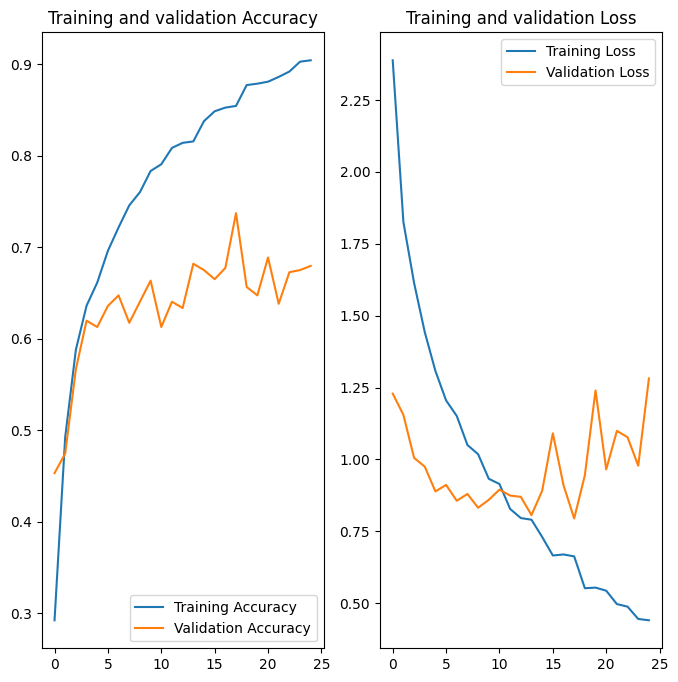

In [6]:
if __name__ == '__main__':
    main()

In [ ]:
flower_category = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
model = GoogLeNet(class_num=5, aux_logits=False)
weights_path = "C:/Users/HKY/Desktop/college/googLeNet/save_weights/myGoogLeNet.ckpt7"
assert len(glob.glob(weights_path + "*")), "cannot find {}".format(weights_path)
model.load_weights(weights_path)


In [12]:
def predict_flower(test_image):
    # resize the test_image
    test_image = cv2.resize(test_image, (224, 224))
    # convert the image to array
    test_image = image.img_to_array(test_image)
    # test_image = image_utils.img_to_array(test_image)
    # expand the dimensions
    test_image = np.expand_dims(test_image, axis=0)
    # predict the image
    result = model.predict(test_image)
    print(result)
    # get the index of the max value
    predict_class = np.argmax(result)
    # return the flower category

    # 该图片为每种花的品种的可能性
    # resultAll = np.squeeze(result)
    # for i in range(len(resultAll)):
    #     print(resultAll[i])

    return flower_category[predict_class]

In [13]:
gr.Interface(fn=predict_flower, inputs="image", outputs="label").launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[[1. 0. 0. 0. 0.]]
